## Proyecto de Geoinformática

### Integrentes: González, Luis; Morgado, Julio & Sanguínes, Baruch.

#### Primera sección de modelos de accesibilidad


In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
import re
import statsmodels.formula.api as smf
from sklearn.neighbors import BallTree
from shapely.geometry import *
from shapely.ops import nearest_points
from access import Access, weights
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import contextily as ctx
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('C:/lrgv/Git/geoinfo_pry/')


**Funciones utilizadas en el código**


In [3]:
# Función para cortar por tramos las ciclovias en conjunto con break_line y cut.
def multi_line(line, dista):
    if line.geom_type == 'MultiLineString':
        segments = []
        for l in line:
            segments += break_line(l, dista)
    else:
        segments = break_line(line, dista)
    return segments

def break_line(line, dist):
    line = LineString([xy[0:2] for xy in list(line.coords)])
    if line.length <= dist:
        return [line]
    else: 
        segments = cut(line, dist)
        return [segments[0]] + break_line(segments[1], dist)

def cut(line, distance):
    if distance <= 0.0 or distance >= line.length:
        return [line]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        p = line.project(Point(p)) 
        if p == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if p > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

# Función de busqueda para los knn vecinos utilizando BallTree
def KN(gdA, gdB, knn=5,dist_lim=1000):
    nA = list(gdA.geometry.apply(lambda x: (x.x, x.y)))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = BallTree(nB)
    dist, idx = btree.query(np.array(nA), k=knn)
    idx = [list(x) for x in list(idx)]
    for i in range(dist.shape[0]):
        rev_j = list(range(dist.shape[1]))
        rev_j.sort(reverse=True)
        for j in rev_j:
            if dist[i,j]>dist_lim:
                del idx[i][j]
                
    rev_i = list(range(dist.shape[0]))
    rev_i.sort(reverse=True)
    for i in rev_i:
        if len(idx[i])==0:
            del idx[i]
            del nA[i]
    return [Point(x) for x in nA], idx

# Función para convertir y dejar pasar tipos de número y texto
def nconv(n):
    try: 
        return float(n)
    except:
        return n

# Función para revisar las observaciones con texto en columna
def var_rev(df, v_int):
    for v in v_int:  
        r = [x for x in list(df[v]) if re.search('\D', str(x))]
        r = [x for x in r if type(nconv(x))==str]
        print(v, set(r), round(len(r)/df.shape[0]*100,4))

**Conversión de ciclovias a tramos de un kilometro**


In [4]:
# Archivo original de ciclovías en la cdmx por la secretaría de obras de la CDMX y SEDEMA.
ciclo = gpd.read_file('data/ciclovias_cdmx.zip').to_crs(32614)
ciclo_lines = pd.DataFrame({'ID':[], 'NOMBRE':[], 'TIPO_IC':[], 
                            'VIALIDAD':[], 'TIPO_VIA':[], 'ESTADO':[], 
                            'SENTIDO':[], 'INSTANCIA':[], 'AÑO':[],'geometry':[]})
for i in range(ciclo.shape[0]):
    df_l = pd.DataFrame({'ID':ciclo.iloc[i,0], 'NOMBRE':ciclo.iloc[i,1],
                         'TIPO_IC':ciclo.iloc[i,2], 
                         'VIALIDAD':ciclo.iloc[i,3],
                         'TIPO_VIA':ciclo.iloc[i,4], 
                         'ESTADO':ciclo.iloc[i,5], 
                         'SENTIDO':ciclo.iloc[i,6],
                         'INSTANCIA':ciclo.iloc[i,7], 
                         'AÑO':ciclo.iloc[i,8],
                         'geometry':(multi_line(ciclo.iloc[i,-1], 1000))})
    ciclo_lines = ciclo_lines.append(df_l)
    
ciclo_lines = gpd.GeoDataFrame(ciclo_lines, crs=32614)
ciclo_lines.reset_index(drop=True, inplace=True)
ciclo_lines.reset_index(inplace=True)
ciclo_lines.columns = [x.lower() for x in ciclo_lines.columns]
ciclo_lines.rename(columns={'index':'fid', 'id':'fid_org', 'año':'year'}, 
                   inplace=True)
ciclo_centroids = ciclo_lines.copy()

# Extraer centroides de cada tramo de linea
ciclo_centroids.loc[:,'geometry'] = ciclo_centroids.geometry.centroid

# Generar variable con codigo unico para cada punto (después es util para el match entre lineas y centroides)
ciclo_centroids = ciclo_centroids.rename(columns={'fid_org':'id_ciclovia', 'fid':'id_centroid'})

# Exportar resultados para llamarlos en futuros modulos
ciclo_lines.to_file('products/ciclovias_lines.gpkg', driver='GPKG', layer='ciclovias')
ciclo_centroids.to_file('products/ciclovias_centroids.gpkg', driver='GPKG', layer='ciclovias_ctr')
del ciclo, df_l, i

**Modelo de demanda**
Para la construcción de la demanda se utilizó información del censo de población y vivienda del 2020 de INEGI. Se realizó un modelo sencillo OLS para poder extrapolar los valores faltantes en la variable de interés *VPH_BICI*. Las variables que se analizaron en el modelo de regresión fueron:
- VPH_BICI: viviendas particulares habitadas que disponen de bicicleta como medio de transporte.
- P_12YMAS: población de 12 años y más; para estimar la población que potencialmente usa bicicleta.
- P_60YMAS: población de 60 años y más; para estimar la población que potencialmente usa bicicleta.
- PDESOCUP: población de 12 años y más desocupada.
- GRAPROES: grado promedio de escolaridad.
- VPH_NDACMM: viviendas particulares habitadas que no disponen de automóvil o camioneta, ni de motocicleta o motoneta.
- POCUPADA: población de 12 años y más ocupada.

In [6]:
mza = gpd.read_file('data/manzanas_cdmx.gpkg').to_crs(32614)
pob = pd.read_csv("data/conjunto_de_datos_ageb_urbana_09_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str, 'MZA':str})
pob['CVEGEO'] = pob['ENTIDAD'] + pob['MUN'] + pob['LOC'] + pob['AGEB'] + pob['MZA']
bi = pd.merge(mza, pob, on='CVEGEO', how='left')
del mza, pob
# Eliminar missing
bi = bi[~bi.GRAPROES.isna()]

v_int = ['VPH_BICI','P_12YMAS','P_60YMAS','PDESOCUP',
         'GRAPROES', 'VPH_NDACMM','POCUPADA']

Primero, se exploró el número de missings o valores reservados por principio de confidencialidad. 

In [7]:
# Revisar valores
var_rev(bi, v_int)

VPH_BICI {'N/D', '*'} 23.1361
P_12YMAS {'N/D', '*'} 2.4741
P_60YMAS {'N/D', '*'} 7.0934
PDESOCUP {'N/D', '*'} 36.4578
GRAPROES {'N/D', '*'} 2.4741
VPH_NDACMM {'N/D', '*'} 8.5554
POCUPADA {'N/D', '*'} 2.5559


La información anterior refiere a que el 23% de las observaciones de la variable *VPH_BICI* tienen un missing o es información confidencial. Por lo tanto se optó por intentar limpiar y quedanos con las variables con menor porcentaje de missings como la población, personal ocupado, grado de escolaridad y viviendas que no disponen de vehículos automotores. 

In [8]:
# Se asume que al menos hay una persona o vivienda con dicha condición
for i in ['P_12YMAS', 'P_60YMAS','VPH_NDACMM','POCUPADA']:
    bi[i] = bi[i].replace('*',1)

var_rev(bi, v_int)

VPH_BICI {'N/D', '*'} 23.1361
P_12YMAS {'N/D'} 0.0045
P_60YMAS {'N/D'} 0.0045
PDESOCUP {'N/D', '*'} 36.4578
GRAPROES {'N/D', '*'} 2.4741
VPH_NDACMM {'N/D'} 0.0045
POCUPADA {'N/D'} 0.0045


Para no afectar mucho la regresión, se añade el promedio de la localidad a las manzanas con missing value de grado de escolaridad. 

In [9]:
# Ingresar el promedio de la localidad en grado de escolaridad para no afectar regresion.
esco = bi[(bi.GRAPROES!='N/D')&(bi.GRAPROES!='*')]
esco['GRAPROES'] = esco.GRAPROES.astype(float)
esco['CVEGEO'] = esco.CVEGEO.apply(lambda x: x[:-7])
esco = esco.groupby('CVEGEO').GRAPROES.mean()
idx = bi[bi.GRAPROES=='*'].index
for i in idx:
    bi.loc[i, 'GRAPROES'] = esco[bi.loc[i, 'CVEGEO'][:-7]]
del esco

var_rev(bi, v_int)

VPH_BICI {'N/D', '*'} 23.1361
P_12YMAS {'N/D'} 0.0045
P_60YMAS {'N/D'} 0.0045
PDESOCUP {'N/D', '*'} 36.4578
GRAPROES {'N/D'} 0.0045
VPH_NDACMM {'N/D'} 0.0045
POCUPADA {'N/D'} 0.0045


Finalmente, eliminando los últimos missings, quedamos con una base de datos como la siguiente. 

In [10]:
# Eliminar los otros missing values de variables dependientes
bi = bi[bi.GRAPROES!='N/D']
var_rev(bi, v_int)

VPH_BICI {'*'} 23.1326
P_12YMAS set() 0.0
P_60YMAS set() 0.0
PDESOCUP {'*'} 36.455
GRAPROES set() 0.0
VPH_NDACMM set() 0.0
POCUPADA set() 0.0


Corremos el primer modelo de regresión con los datos completos, sin missings y con el mayor número de observaciones. 

In [12]:
# Modelo de regresión para completar VPH_BICI
v_mod = ['VPH_BICI','P_12YMAS','P_60YMAS','GRAPROES','VPH_NDACMM','POCUPADA']
bi_mod = bi[v_mod][bi.VPH_BICI!='*']
for v in ['VPH_BICI','P_12YMAS','P_60YMAS','GRAPROES','VPH_NDACMM','POCUPADA']:
    bi_mod[v] = bi_mod[v].astype(float)
    if v!='VPH_BICI':
        bi[v] = bi[v].astype(float)

# Generar variable de población potencial al uso de bici
bi_mod['pob'] = bi_mod['P_12YMAS'] - bi_mod['P_60YMAS']

# Controlar la población ocupada por población total
bi_mod['pocu'] = bi_mod['POCUPADA']/bi_mod['P_12YMAS']
mod = smf.ols('VPH_BICI ~ pob + GRAPROES + pocu + VPH_NDACMM', data=bi_mod).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               VPH_BICI   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                 2.135e+04
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        00:46:20   Log-Likelihood:            -1.7176e+05
No. Observations:               47422   AIC:                         3.435e+05
Df Residuals:                   47417   BIC:                         3.436e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.9002      0.359    -38.716      0.0

Naturalmente, el modelo de regresión presenta graves probles de multicolinearidad y correlación con errores. Sin embargo, podemos observar que con las variables de población potencial, grado de escolaridad y viviendas sin automotores nos pueden ayudar a extrapolar la variable de interés.  

In [13]:
bi['pob'] = bi['P_12YMAS'] - bi['P_60YMAS']
bi['pocu'] = bi['POCUPADA']/bi['P_12YMAS']
bi['bici_pred'] = mod.predict(exog=bi[['pob','GRAPROES','pocu','VPH_NDACMM']])
bi.loc[bi.VPH_BICI=='*','VPH_BICI'] = bi.loc[bi.VPH_BICI=='*','bici_pred'] 
var_rev(bi, v_int)
bi['VPH_BICI'] = bi.VPH_BICI.astype(float)
bi.loc[bi.VPH_BICI<0, 'VPH_BICI'] = 0
bi.VPH_BICI.describe()

VPH_BICI set() 0.0
P_12YMAS set() 0.0
P_60YMAS set() 0.0
PDESOCUP {'*'} 36.455
GRAPROES set() 0.0
VPH_NDACMM set() 0.0
POCUPADA set() 0.0


count    66002.000000
mean         9.083456
std         13.378314
min          0.000000
25%          3.000000
50%          5.712419
75%         11.000000
max        819.000000
Name: VPH_BICI, dtype: float64

Ahora desarrollamos la base de datos final de ciclovias y su demanda respecto al número de viviendas particulares habitadas que reportan el uso de la bicicleta como medio de transporte. 

In [14]:
# Obtener cetroides de las manzanas y poder relizar el knn
bi['geometry'] = bi.geometry.centroid

# Cargar centroides de tramos de ciclovias.
cl = gpd.GeoDataFrame(gpd.read_file('products/ciclovias_centroids.gpkg'), geometry='geometry', crs=32614)[['id_centroid','geometry']]

# Calcular las 3 manzanas más cercanas y de menor distancia que 1km para cada tramo de ciclovía
points, knn_points = KN(cl, bi, 3, 1000)

count = pd.DataFrame({'idx':[j for i in knn_points for j in i]}).value_counts().reset_index()
count.columns = ['idx','kn']
count.set_index('idx', inplace=True)

dem = pd.concat([bi,count], axis=1)
dem['kn'] = dem.kn.fillna(1)
dem['demanda_pond'] = dem['VPH_BICI']/dem['kn']

# Pegar al geodataframe la demanda estimada.
for i in range(len(points)):
    cl.loc[cl.geometry==points[i], 'POBTOT'] = int(dem.iloc[knn_points[i],-1].sum())


Hacemos una previsualización de nuestra demanda y guardamos los resultados. 

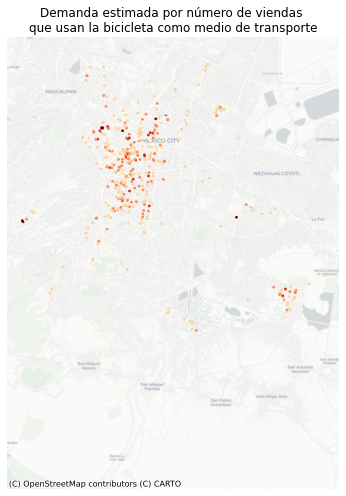

In [38]:
ax = cl.to_crs(epsg=3857).plot(column='POBTOT', scheme='naturalbreaks',
                               markersize=3, cmap='OrRd', figsize=(7,7))
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) 
ax.set_axis_off()
plt.title('Demanda estimada por número de viendas \nque usan la bicicleta como medio de transporte')
plt.tight_layout()
plt.show()

# Exportamos base de datos final de demanda.
gpd.GeoDataFrame(cl[['id_centroid','POBTOT','geometry']]).to_file('products/ciclovias_centroids_demand.gpkg', driver='GPKG', layer='ciclovias')

Una vez con la demanda estimada, pasamos a calcular el modelo de accesibilidad gravitatorio y por el modelo de agente racional RAAM. Primero, calculamos el modelo gravitacional utilizando como oferta el tamaño del establecimiento; en este caso, el número de empleados registrados en el DENUE en cada taller de bicicletas. Previsualizamos la información tanto de talleres como ciclovias y su demanda. 

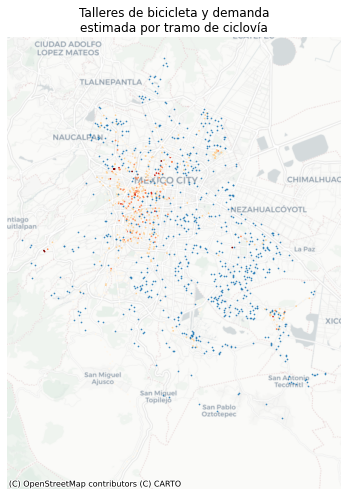

In [43]:
cl = gpd.read_file('products/ciclovias_centroids_demand.gpkg').to_crs(epsg=3857)

ta = gpd.read_file('Talleres_Bici.gpkg')
ta['per_ocu'] = ta.per_ocu.apply(lambda x: 1 if x=='0 a 5 personas' else 2)
ta = ta.to_crs(epsg=3857)

ax = cl.plot(column='POBTOT', scheme='naturalbreaks', 
             markersize=.5, cmap='OrRd', figsize=(7,7))
ta.plot(ax=ax, markersize=0.5, alpha=0.8)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) 
ax.set_axis_off()
plt.title('Talleres de bicicleta y demanda\nestimada por tramo de ciclovía')
plt.tight_layout()
plt.show()


Seguimos al cálculo del modelo gravitacional

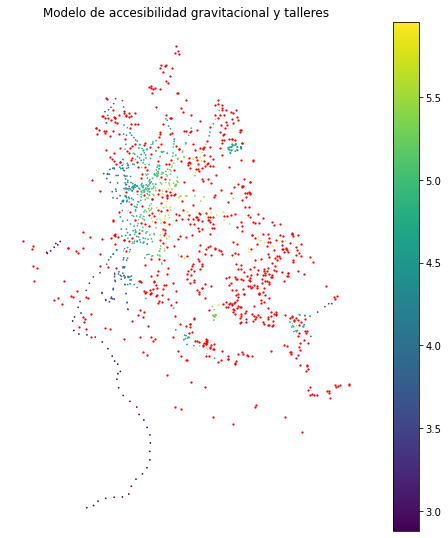

In [46]:
# Creamos el objeto access para calcular distancia euclidiana
A = Access(demand_df            = cl,
           demand_index         = 'id_centroid',
           demand_value         = 'POBTOT',
           supply_df            = ta,
           supply_index         = 'id',
           supply_value         = 'per_ocu')

# Calculamos las distancias
A.create_euclidean_distance(threshold = 250000, centroid_o = True, centroid_d = True)
cost = A.cost_df
gravity = weights.gravity(scale = 60, alpha = -1)
gravity_mod = A.weighted_catchment(name='gravity', weight_fn=gravity)

fig = cl[['id_centroid','geometry']].set_index('id_centroid').join(A.access_df, how='inner')
base = fig.plot('gravity_per_ocu', legend = True, 
                figsize = (8, 8), 
                cmap = 'viridis', 
                markersize = .5, 
                alpha = 1,
                vmin = fig['gravity_per_ocu'].quantile(0.05), 
                vmax = fig['gravity_per_ocu'].quantile(0.95))
# Plot it twice, so that the points' edgecolor does not hide other points' centers.
ta.plot(ax=base, markersize=20, color='white')
ta.plot(ax=base, markersize=5, color='red', edgecolor = "white", linewidth = 0)
plt.title('Modelo de accesibilidad gravitacional y talleres')
plt.tight_layout()
base.set_axis_off()
plt.show()

Pasamos el modelo de Agente Racional.

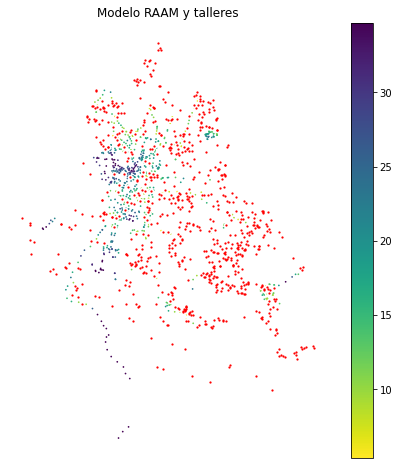

In [47]:
# Creamos modelo access
A = Access(demand_df            = cl,
           demand_index         = 'id_centroid',
           demand_value         = 'POBTOT',
           supply_df            = ta,
           supply_index         = 'id',
           supply_value         = 'per_ocu',
           cost_df              = cost,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'euclidean')
raam_mod = A.raam(name='raam')

# Mapeamos el resultado
cmap = matplotlib.cm.viridis
fig = cl[['id_centroid','geometry']].set_index('id_centroid').join(A.access_df, how='inner')
base = fig.plot('raam_per_ocu', legend = True, 
                figsize = (8, 8), 
                cmap = cmap.reversed(), 
                markersize = .5, 
                alpha = 1,
                vmin = fig['raam_per_ocu'].quantile(0.05), 
                vmax = fig['raam_per_ocu'].quantile(0.95))
# Plot it twice, so that the points' edgecolor does not hide other points' centers.
ta.plot(ax=base, markersize=20, color='white')
ta.plot(ax=base, markersize=5, color='red', edgecolor = "white", linewidth = 0)
base.set_axis_off()
plt.title('Modelo RAAM y talleres')
plt.show()

Comparamos ambos modelos: 


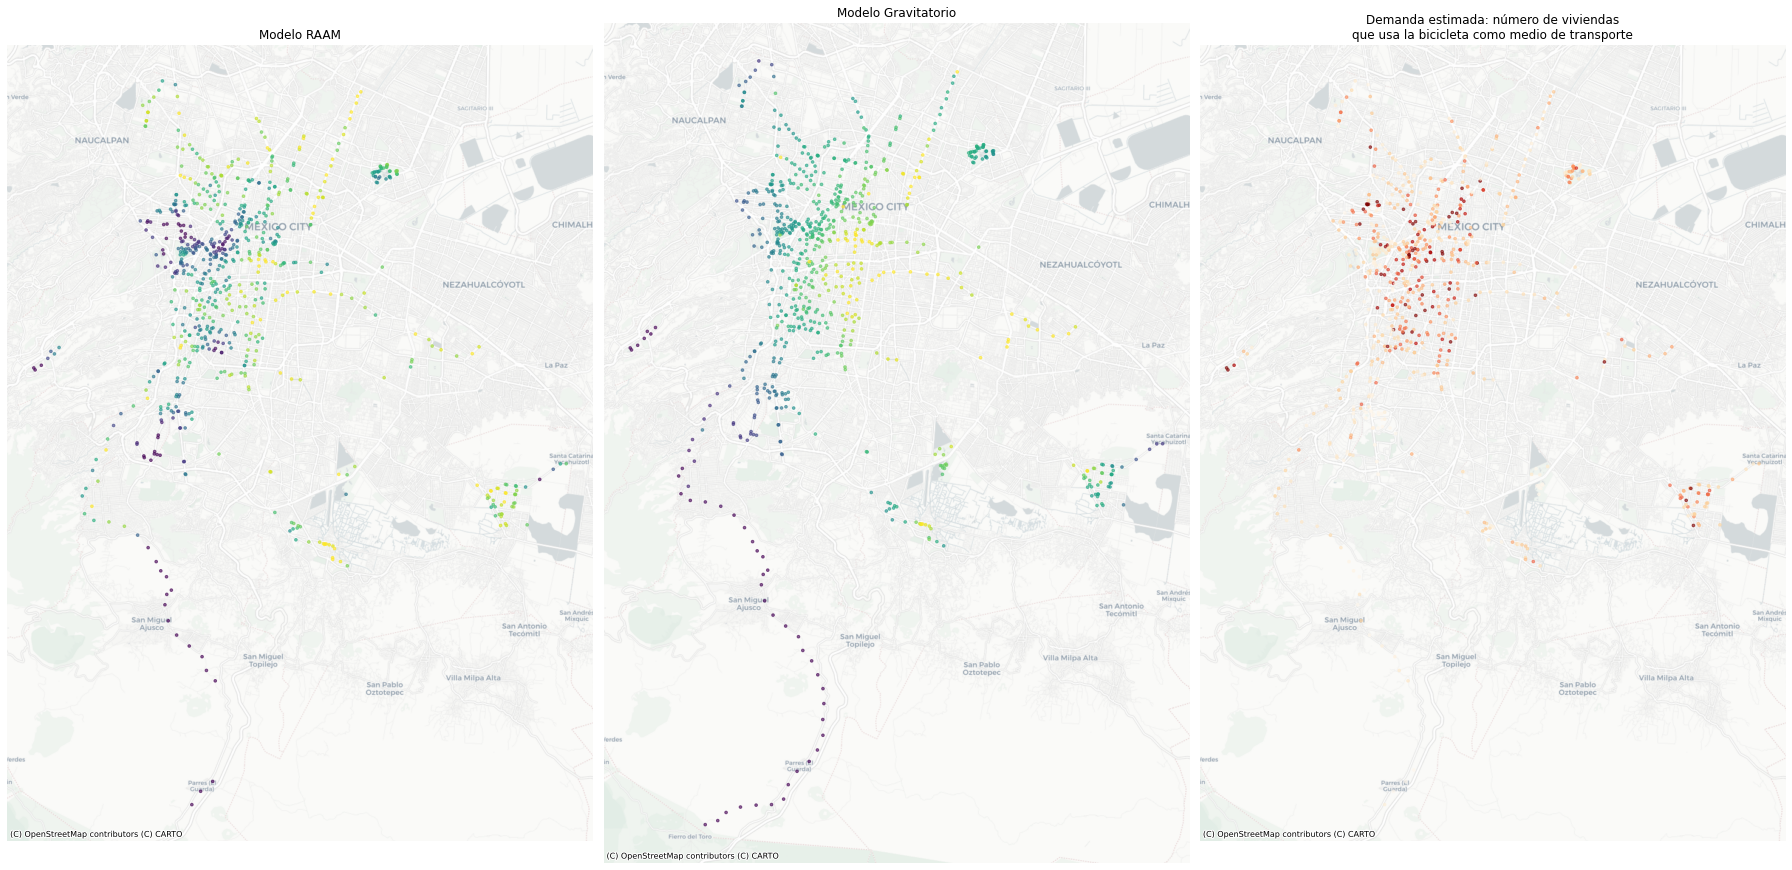

In [48]:
# Guardamos información
mapa_accesibilidad = cl.set_index('id_centroid')[['geometry','POBTOT']].join([gravity_mod,raam_mod], how = "inner")
mapa_accesibilidad.columns = ['geometry','demanda','gravity','raam']

fig, ax = plt.subplots(1,3, figsize=(25,15))
cmap = matplotlib.cm.viridis
mapa_accesibilidad.to_crs(epsg=3857).plot('raam', legend = False,
                                          cmap =  cmap.reversed(), 
                                          markersize = 7, alpha = 0.6, ax = ax[0],
                                          vmin = mapa_accesibilidad['raam'].quantile(0.05), 
                                          vmax = mapa_accesibilidad['raam'].quantile(0.95),
                                          )
mapa_accesibilidad.to_crs(epsg=3857).plot('gravity', legend = False,
                                          cmap =  cmap, 
                                          markersize = 7, alpha = 0.6, ax = ax[1],
                                          vmin = mapa_accesibilidad['gravity'].quantile(0.05), 
                                          vmax = mapa_accesibilidad['gravity'].quantile(0.95),
                                          )
mapa_accesibilidad.to_crs(epsg=3857).plot('demanda', legend = False,
                                          cmap = 'OrRd', 
                                          markersize = 7, alpha = 0.6, ax = ax[2],
                                          vmin = mapa_accesibilidad['demanda'].quantile(0.05), 
                                          vmax = mapa_accesibilidad['demanda'].quantile(0.95),
                                          )
ax[0].set(title='Modelo RAAM')
ax[1].set(title='Modelo Gravitatorio')
ax[2].set(title='Demanda estimada: número de viviendas\nque usa la bicicleta como medio de transporte')
for i in range(len(ax)):
    ax[i].set_axis_off()
    ctx.add_basemap(ax[i], source=ctx.providers.CartoDB.Positron)    
plt.tight_layout()
plt.show()

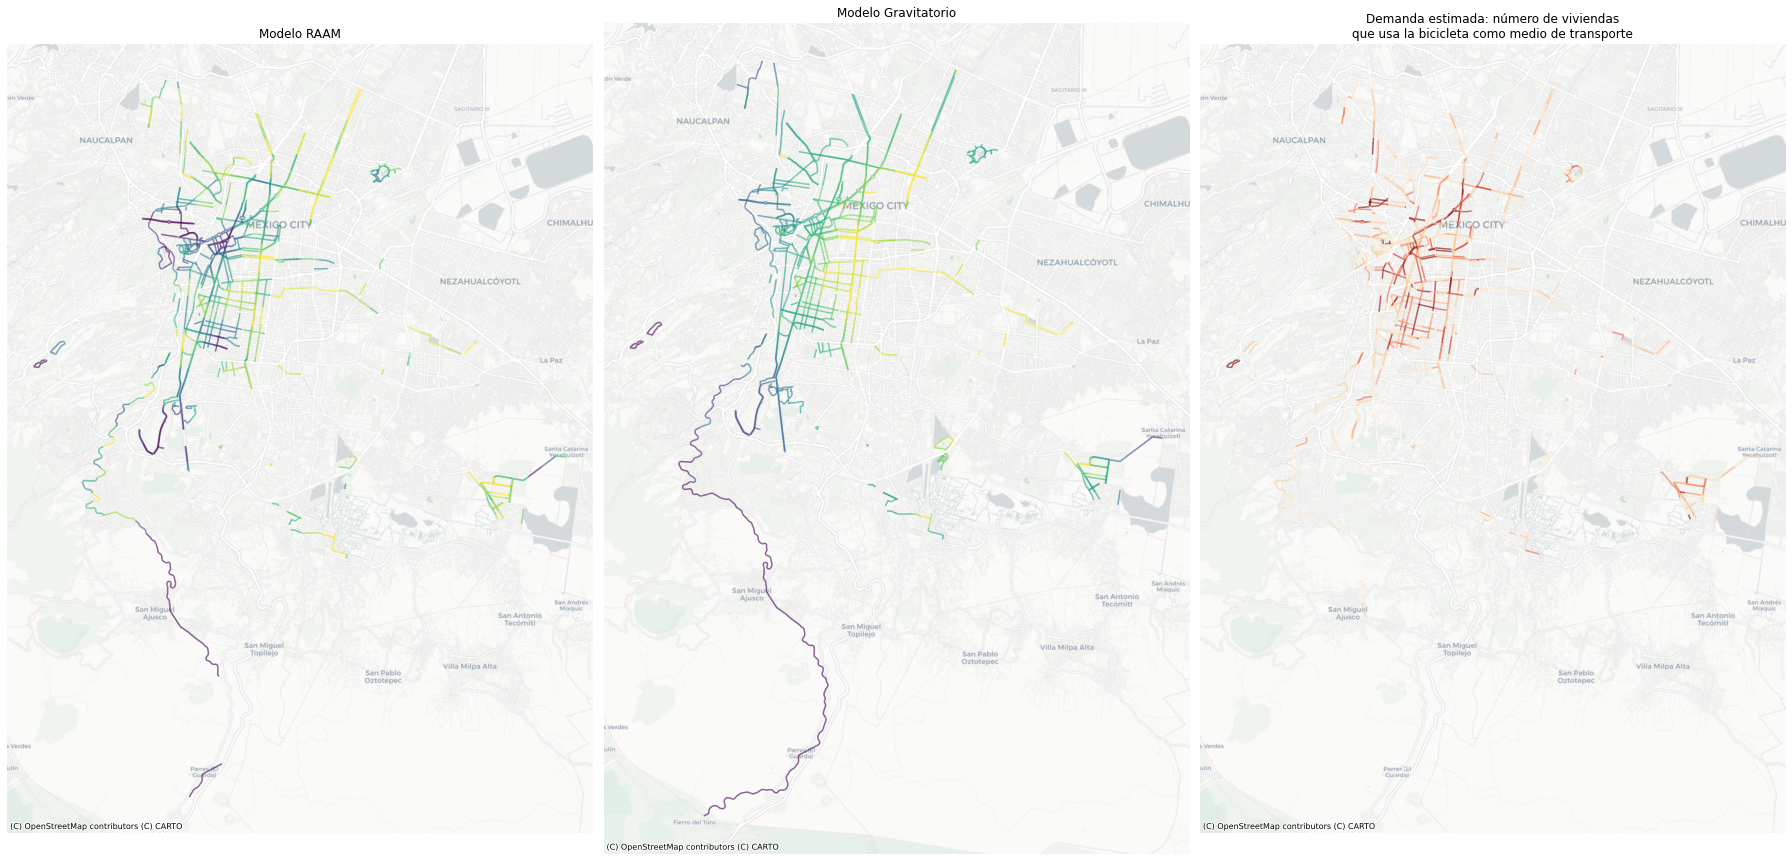

In [49]:
# Mapas con ciclovias lineales
cll = gpd.read_file('products/ciclovias_lines.gpkg').to_crs(3857)
cll = cll.join(mapa_accesibilidad[['raam','gravity','demanda']])

fig, ax = plt.subplots(1,3, figsize=(25,15))
cmap = matplotlib.cm.viridis
cll.to_crs(epsg=3857).plot('raam', legend = False,
                           cmap =  cmap.reversed(), 
                           markersize = 7, alpha = 0.6, ax = ax[0],
                           vmin = mapa_accesibilidad['raam'].quantile(0.05), 
                           vmax = mapa_accesibilidad['raam'].quantile(0.95))
cll.to_crs(epsg=3857).plot('gravity', legend = False,
                           cmap =  cmap, 
                           markersize = 7, alpha = 0.6, ax = ax[1],
                           vmin = mapa_accesibilidad['gravity'].quantile(0.05),
                           vmax = mapa_accesibilidad['gravity'].quantile(0.95))
cll.to_crs(epsg=3857).plot('demanda', legend = False,
                           cmap = 'OrRd', 
                           markersize = 7, alpha = 0.6, ax = ax[2],
                           vmin = mapa_accesibilidad['demanda'].quantile(0.05), 
                           vmax = mapa_accesibilidad['demanda'].quantile(0.95))
ax[0].set(title='Modelo RAAM')
ax[1].set(title='Modelo Gravitatorio')
ax[2].set(title='Demanda estimada: número de viviendas\nque usa la bicicleta como medio de transporte')
for i in range(len(ax)):
    ax[i].set_axis_off()
    ctx.add_basemap(ax[i], source=ctx.providers.CartoDB.Positron)    
plt.tight_layout()
plt.show()

# Exportamos datos
mapa_accesibilidad.to_crs(32614).to_file('products/ciclovias_accesibilidad.gpkg', driver='GPKG', layer='accesibilidad')

#### Segunda sección de índices espaciales

In [50]:
#Paquetería requerida
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.neighbors import BallTree
from shapely.geometry import *
from time import process_time
import osmnx as ox
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('C:/lrgv/Git/geoinfo_pry/')

**Funciones utlizadas**

In [51]:
#Función para busqueda con índice espacial
def espacial(puntos, poligono):
    if len(set(poligono.index.duplicated()))>1:
        print('CUIDADO, tu poligonos tienen índices repetidos')
    si = puntos.sindex
    
    pmi = []
    ide = []
    for poly in poligono.itertuples():
        c = list(si.intersection(poly.geometry.bounds))
        pmi += c
        ide += [poly.Index]*len(c)

    pm = puntos.iloc[list(set(pmi))]

    result = pm.loc[pm.intersects(poligono.unary_union)]
    result['id_busqueda'] = ide
    return result

#Función para busqueda sin índice espacial
def normal(puntos, poligono):    
    pm = []
    ide = []
    for poly in poligono.itertuples():
        c = list(puntos.loc[puntos.intersects(poly.geometry)].index)
        pm += c
        ide += [poly.Index]*len(c)

    result = puntos.loc[puntos.index.isin(list(set(pm)))]
    result['id_busqueda'] = ide
    return result

# Buscador avanzado de tramo de ciclovia y si hay talleres cerca con y sin índice espacial
def buscador(tramo_ciclovia, talleres, zonas, usar_spindex=True):
    if usar_spindex:
        step1 = espacial(tramo_ciclovia, zonas).id_busqueda.unique()
        if len(step1)>0:
            return espacial(talleres, zonas.iloc[step1, :])
        else:
            print('Lo siento, este tramo de ciclovía no está en la CDMX')
    else:
        step1 = normal(tramo_ciclovia, zonas).id_busqueda.unique()
        if len(step1)>0:
            return normal(talleres, zonas.iloc[step1, :])
        else:
            print('Lo siento, este tramo de ciclovía no está en la CDMX')     

# Buscador de taller con BallTree con un radio especifico a la redonda
def buscador_ball(tramo_ciclovia, talleres, radio):
    t = np.array(list(talleres.geometry.apply(lambda x: (x.x, x.y))))
    c = np.array(list(tramo_ciclovia.geometry.apply(lambda x: (x.x, x.y))))
    btree = BallTree(t)
    idx = btree.query_radius(c, radio)
    idx = [list(x) for x in idx]
    return c, t, idx

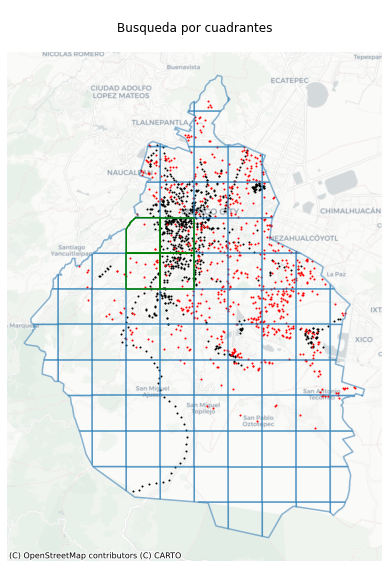

In [54]:
# Cargar áreas de la CDMX, centroides de tramos de ciclovía, red de ciclovías y talleres de bici
cdmx = gpd.read_file("data/cdmx.gpkg").to_crs(3857)[['CVE_ENT', 'geometry']]
cl = gpd.read_file('products/ciclovias_centroids_demand.gpkg').to_crs(3857)[['id_centroid','geometry']]
cll = gpd.read_file('products/ciclovias_lines.gpkg').to_crs(3857)
ta = gpd.read_file('Talleres_Bici.gpkg').to_crs(3857)[['id', 'geometry']]

# Crear zonas de cdmx cada 5km
cdmx_zonas = gpd.GeoDataFrame()
for i, poly in enumerate(ox.utils_geo._quadrat_cut_geometry(cdmx['geometry'][0], quadrat_width=5000)):
    cdmx_zonas = cdmx_zonas.append(gpd.GeoDataFrame(index=[i], crs=3857, geometry=[poly]))

fig, ax = plt.subplots(figsize=(8,8))
cdmx_zonas.boundary.plot(ax=ax, alpha=0.5)
cdmx_zonas.iloc[[62,63,76,77],:].boundary.plot(ax=ax, color='green')
cl.plot(ax=ax, color='black', markersize=1)
ta.plot(ax=ax, color='red', markersize=1)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)  
ax.set_axis_off()
plt.title('\nBusqueda por cuadrantes\n')
plt.tight_layout()
plt.show()

Comparación de tiempos utilizando muestras, toda la base de datos y con y sin índices espaciales. Como se puede ver en el código la diferencia es bastante cuando se habla de una mayor cantidad de datos. En este caso, cuando se utiliza toda la base de datos se obtiene una ventaja de casí la mitad de tiempo. 

In [55]:
poly = cdmx_zonas.iloc[[62,63,76,77],:]

s=process_time()
espacial(cl, poly)
s1 = process_time() - s
print('Tiempo con submuestra e índice espacial: ', round(s1, 4))

s=process_time()
normal(cl, poly)
s2 = process_time() - s
print('Tiempo con submuestra SIN índice espacial: ', round(s2, 4))
print('Razón de diferencia: ', round(s2/s1-1, 2))

s=process_time()
espacial(cl, cdmx_zonas)
s1 = process_time() - s
print('Tiempo con todos e índice espacial: ', round(s1, 4))

s=process_time()
normal(cl, cdmx_zonas)
s2 = process_time() - s
print('Tiempo con todos SIN índice espacial: ', round(s2, 4))
print('Razón de diferencia: ', round(s2/s1-1, 2))

Tiempo con submuestra e índice espacial:  0.0625
Tiempo con submuestra SIN índice espacial:  0.0156
Razón de diferencia:  -0.75
Tiempo con todos e índice espacial:  0.2344
Tiempo con todos SIN índice espacial:  0.3438
Razón de diferencia:  0.47


Ahora, se desarrolló una busqueda anidada donde primero se busca si en el cuadrante hay ciclovías y, posteriormente, hay talleres en el mismo cuadrante. 

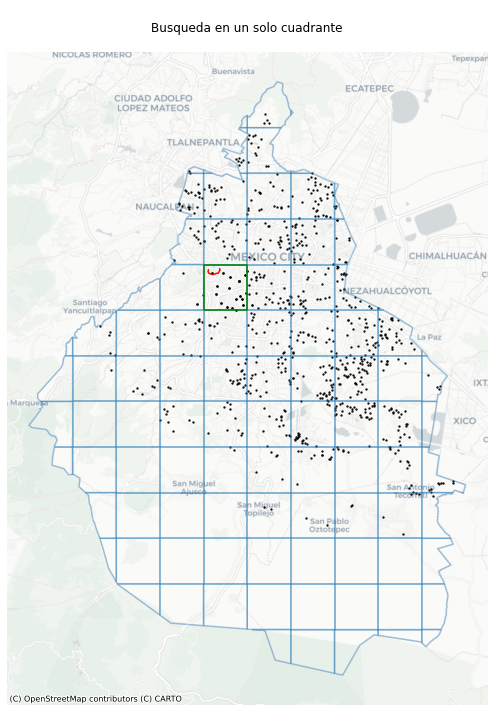

In [56]:
# Programa para buscar ciclovias y talleres
ciclovias = cl.iloc[:2,:]
resultado = buscador(ciclovias, ta, cdmx_zonas)

fig, ax = plt.subplots(figsize=(10,10))
cdmx_zonas.boundary.plot(ax=ax, alpha=0.4)
ta.plot(ax=ax, alpha=0.8, markersize=2, color='black')
cdmx_zonas.iloc[resultado.id_busqueda.unique()].boundary.plot(ax=ax, color='green')
resultado.plot(ax=ax, color='black', markersize=2)
cll.iloc[list(ciclovias.index), :].plot(ax=ax, color='red')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)  
ax.set_axis_off()
plt.title('\nBusqueda en un solo cuadrante\n')
plt.tight_layout()
plt.show()


Igual que el ejercicio anterior, se utlizó una muestra de ciclovías y toda la red para hacer la busqueda de talleres. 

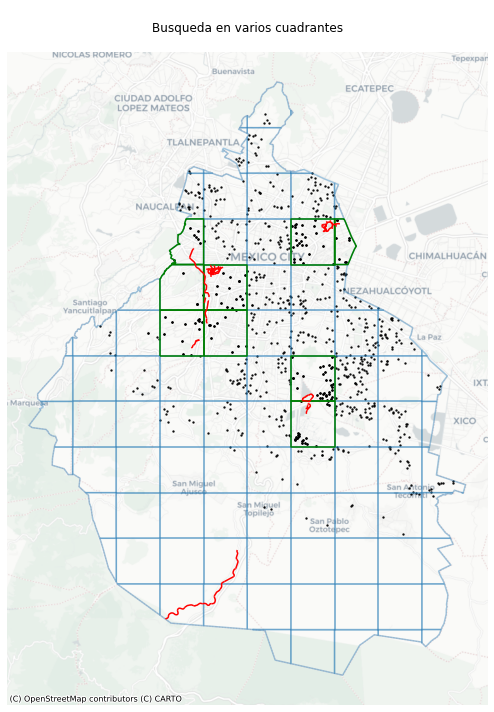

In [57]:
ciclovias = cl.iloc[:100,:]
resultado = buscador(ciclovias, ta, cdmx_zonas)

fig, ax = plt.subplots(figsize=(10,10))
cdmx_zonas.boundary.plot(ax=ax, alpha=0.4)
ta.plot(ax=ax, alpha=0.8, markersize=2, color='black')
cdmx_zonas.iloc[resultado.id_busqueda.unique()].boundary.plot(ax=ax, color='green')
resultado.plot(ax=ax, color='black', markersize=2)
cll.iloc[list(ciclovias.index), :].plot(ax=ax, color='red')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)  
ax.set_axis_off()
plt.title('\nBusqueda en varios cuadrantes\n')
plt.tight_layout()
plt.show()

A diferencia del índice espacial anterior, también se añadió BallTree que es otra forma de hacer un árbol pero utilizando radios o *buffers*. 


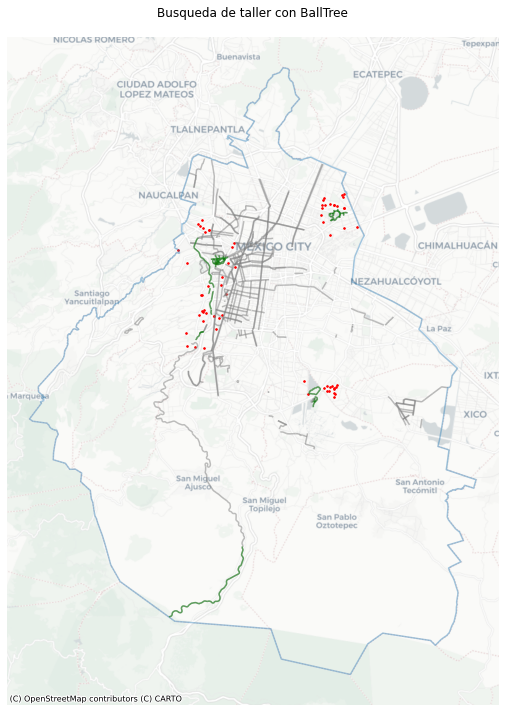

In [58]:
ciclovias = cl.iloc[:100,:]
cl_geom, _, idx = buscador_ball(ciclovias, ta, 2000)
cl_geom = [Point(x) for x in cl_geom]
idx = list(set([i for j in idx for i in j]))

fig, ax = plt.subplots(figsize=(10,10))
cll.plot(ax=ax, alpha=0.5, color='gray')
cdmx.boundary.plot(ax=ax, alpha=0.4)
cll.iloc[list(cl[cl.geometry.isin(cl_geom)].id_centroid),:].plot(ax=ax,color='green',alpha=0.5)
ta.iloc[idx, :].plot(ax=ax, color='red', markersize=2.5)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)  
ax.set_axis_off()
plt.title('Busqueda de taller con BallTree\n')
plt.tight_layout()
plt.show()

Comparamos tiempos tanto del RTree como del BallTree a la luz de utilizar una programación sin índices espaciales. 

In [59]:

s=process_time()
buscador(cl, ta, cdmx_zonas)
s1= process_time() - s
print('Tiempo con RTree: ', round(s1, 4))

s=process_time()
buscador_ball(cl, ta, 1500)
s2= process_time() - s
print('Tiempo con BallTree: ', round(s2, 4))

s=process_time()
buscador(cl, ta, cdmx_zonas, False)
s3= process_time() - s
print('Tiempo sin índice : ', round(s3, 4))

print('Diference respecto al RTree {}, y al Ball {}'.format(round(s3/s1-1, 3), round(s3/s2-1, 3)))

Tiempo con RTree:  0.3281
Tiempo con BallTree:  0.0469
Tiempo sin índice :  0.4531
Diference respecto al RTree 0.381, y al Ball 8.667


#### Sección de Paralelización

In [68]:
import pandas as pd
import geopandas as gpd
import numpy as np
from joblib import Parallel, delayed
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('C:/lrgv/CruzRoja/1.Investigacion/')
gitdir = 'C:/lrgv/Git/cruzroja/'
shpfile = 'C:/lrgv/Shapefiles/'
plt.style.use('seaborn-white')

**Funciones utilizadas**


In [69]:
# Función para pegar el código CIE dependiendo del nivel de detalle
def cie(df, var_cie, n_cie=None):
    if n_cie!=None:
        df[var_cie] = df[var_cie].apply(lambda x: x[:n_cie])
    cie = pd.read_csv('datos/Lesiones/Catalogos_Lesiones_2020/CAT_CIE-10_2020.csv', 
                      index_col=None, encoding='latin')[['Clave','Nombre']].rename(columns={'Clave':var_cie})
    return pd.merge(df, cie, on=var_cie, how='left')

# Cambiar las etiquetas de variable prehospitalaria
def prehosp(series):
    if series==1:
        return 'Si'
    elif series==2:
        return 'No'
    else:
        np.nan

# Poner enter a lineas de texto en CIE 
def pal_lineas(txt):
    t = []
    if len(txt.split(' '))>4:
        c = 4
        while c<len(txt.split(' ')):
            t.append(' '.join(txt.split(' ')[c-4:c]) + '\n')
            c+=4
        t.append(' '.join(txt.split(' ')[c-4:]))
        return ' '.join(t)
    else:
        return txt

# Graficar los resultados de función
def graph_map_bar(info):
    for i in range(len(info[0])):
        df = gpd.GeoDataFrame(pd.DataFrame(info[i][0]), geometry=0, crs=3857)
        df.columns = ['geometry','values']
        df['values'] = df['values'].astype(float)
        dff = pd.DataFrame(info[1][i])
        dff.columns = ['tipo','value']
        dff.iloc[:,0] = dff.iloc[:,0].apply(lambda x: pal_lineas(x))
        
        fig, ax = plt.subplots(1,2,figsize=(20,8), gridspec_kw={'width_ratios': [1, 2]})
        sns.barplot(data=dff, x='value', y='tipo', ax=ax[0], 
                    palette=reversed(sns.color_palette('Blues', dff.shape[0])))
        df.plot('values', cmap='Blues', scheme='naturalbreaks', ax=ax[1])
        ax[1].set_axis_off()
        ax[0].set_title('Principales afecciones de lesiones\nque requirieron atención prehospitalaria')
        ax[0].set_ylabel('')
        ax[0].set_xlabel('')
        ax[1].set_title('Concentración de lesiones que \nrequirieron atención prehospitalaria')
        plt.tight_layout()
        plt.show()

**Función a paralelizar**

In [70]:
def map_bar(ent):
    # Carga de polígonos a nivel localidad
    shp = gpd.read_file(shpfile + 'Localidad urbana/Localidades_urbanas2013.shp')[['ClAVE','geometry']]
    shp.columns = ['cvegeo','geometry']
    shp.set_index('cvegeo', inplace=True)
    resultados = [[],[]]
    les = pd.read_csv('datos/Lesiones/Lesiones_2020/D_Evento.txt', index_col='ID',
                      dtype={'CodEstado':str, 'CodMunicipio':str, 'CodLocalidad':str})
    les = les[les.CodLocalidad!='9999']
    les['cvegeo'] = les['CodEstado'] + les['CodMunicipio'] + les['CodLocalidad']
    les['CodPrehospitalaria'] = les.CodPrehospitalaria.apply(lambda x: prehosp(x))
    
    # Generar lesiones por localidad que usaron servicios prehosp
    df = les[les.CodEstado==ent].groupby(['cvegeo','CodPrehospitalaria']).size().unstack()
    df.fillna(0, inplace=True)
    df['les_per100'] = round(df.iloc[:,1]/((df.iloc[:,1]+df.iloc[:,0])/100),0)
    df = pd.concat([df, shp], axis=1, join='inner')
    resultados[0].append(np.array(df[['geometry','les_per100']]))
    del df
    
    # Generar principales afecciones por localidad
    df= les[(les.CodEstado==ent)&(les.CodPrehospitalaria=='Si')].groupby(['cvegeo','AFECPRIN'], as_index=False).size()
    df = cie(df, 'AFECPRIN', 3)
    df = df.groupby(['AFECPRIN','Nombre'], as_index=False)['size'].sum()
    df.sort_values('size',ascending=False, inplace=True)
    resultados[1].append(np.array(df.head(10)[['Nombre','size']]))
    del df
    return resultados

Prueba de la función

In [71]:
var_edos = [str(x).zfill(2) for x in list(range(1,33))]
 
# Ejemplo con la CDMX
r = map_bar(var_edos[8])

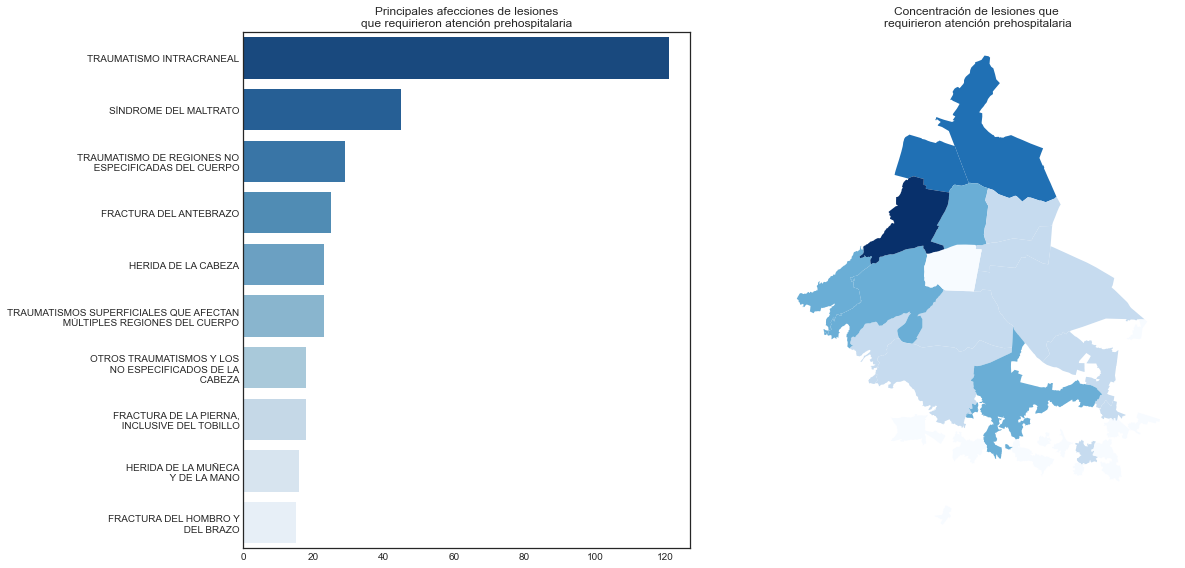

In [72]:
graph_map_bar(r)

**Pruebas de tiempo**

In [73]:
%%time
r = []
for i in var_edos:
    r.append(map_bar(i))

Wall time: 1min 56s


In [ ]:
%%time
r = Parallel(n_jobs=1,backend='multiprocessing')(delayed(map_bar)(i) for i in var_edos)